In [1]:
import pandas as pd
from hnmchallenge.data_reader import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hnmchallenge.dataset import Dataset
from hnmchallenge.filtered_dataset import FilterdDataset
from hnmchallenge.models.top_pop import TopPop
from hnmchallenge.evaluation.python_evaluation import map_at_k
from hnmchallenge.constant import *
from hnmchallenge.models.sgmc.sgmc import SGMC
from hnmchallenge.models.ease.ease import EASE
from hnmchallenge.models.itemknn.itemknn import ItemKNN 

In [2]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [3]:
dataset = FilterdDataset()
dr = DataReader()

In [4]:
fd = dr.get_filtered_full_data()

In [5]:
fd.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,0,0,0.008458,2
1,2018-09-20,0,0,0.008458,2
2,2018-09-20,1,1,0.033881,1
3,2018-09-20,2,2,0.021593,1
4,2018-09-20,3,3,0.022017,2


In [6]:
item_per_user = fd.groupby("customer_id")["article_id"].apply(list)

In [7]:
unique_item_per_user = item_per_user.apply(np.unique)

In [8]:
df_multiple = item_per_user.to_frame()
df_unique = unique_item_per_user.to_frame()

In [14]:
df_multiple["count"] = df_multiple.apply(lambda row: len(row["article_id"]), axis=1)
df_unique["count"] = df_unique.apply(lambda row: len(row["article_id"]), axis=1)

In [17]:
merge_df = pd.merge(df_multiple, df_unique, on="customer_id")

In [18]:
merge_df["diff"] = 1 - (merge_df["count_y"]/merge_df["count_x"])

Text(0.5, 0, 'user tendency buying multiple items')

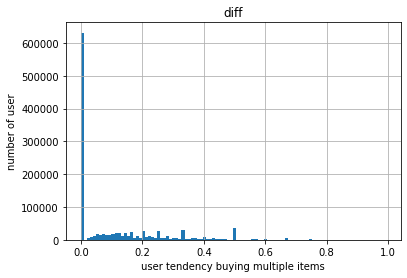

In [21]:
merge_df.hist("diff", bins=100)
plt.ylabel("number of user")
plt.xlabel("user tendency buying multiple items")

# Percentage multiple items bought on the same day

In [22]:
nn = fd.groupby(["article_id", "customer_id", "t_dat"]).count()

In [23]:
ll = nn[nn["price"]>1]
ll

price  sales_channel_id
article_id customer_id t_dat                              
0          0           2018-09-20      2                 2
           1220        2019-06-15      2                 2
           1226        2019-08-18      2                 2
           4118        2018-12-19      2                 2
           5351        2019-12-17      2                 2
...                                  ...               ...
22051      442400      2020-09-22      2                 2
22057      27310       2020-09-22      2                 2
22060      280338      2020-09-22      2                 2
22062      749097      2020-09-22      2                 2
22066      1136114     2020-09-22      2                 2

[1320507 rows x 2 columns]

In [24]:
pp = fd.groupby(["article_id", "customer_id"]).count()

In [25]:
mm = pp[pp["price"]>1]
mm

t_dat  price  sales_channel_id
article_id customer_id                                
0          0                3      3                 3
           135              2      2                 2
           1220             3      3                 3
           1226             3      3                 3
           1503             2      2                 2
...                       ...    ...               ...
22051      442400           2      2                 2
22057      27310            2      2                 2
22060      280338           2      2                 2
22062      749097           2      2                 2
22066      1136114          2      2                 2

[1722031 rows x 3 columns]

In [26]:
1320507/1722031

0.7668311429933607

# Multiple time an item will be bought if the item has to be bought multiple time.

In [28]:
item_count_per_user = fd.groupby(["customer_id", "article_id", ]).count()

In [29]:
item_count_per_user

t_dat  price  sales_channel_id
customer_id article_id                                
0           0               3      3                 3
            644             1      1                 1
            1482            1      1                 1
            1638            1      1                 1
            1652            1      1                 1
...                       ...    ...               ...
1136205     1765            1      1                 1
            7580            1      1                 1
            10033           1      1                 1
            12955           1      1                 1
            15003           1      1                 1

[12106980 rows x 3 columns]

In [32]:
# considering item that have been bought at least once more than once
item_mb = item_count_per_user[item_count_per_user["price"]>1]
avg_item_mb = item_mb.groupby("article_id").mean()

In [41]:
avg_item_mb

,t_dat,price,sales_channel_id
article_id,,,
0,2.364224,2.364224,2.364224
1,2.303502,2.303502,2.303502
2,2.263158,2.263158,2.263158
3,2.543919,2.543919,2.543919
4,2.895122,2.895122,2.895122
...,...,...,...
22051,2.000000,2.000000,2.000000
22057,2.000000,2.000000,2.000000
22060,2.000000,2.000000,2.000000


Text(0, 0.5, 'avg multiple buy')

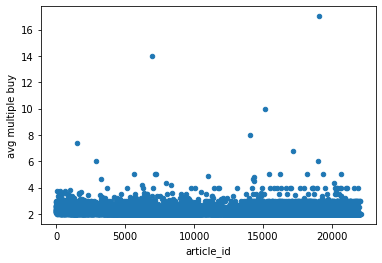

In [58]:
avg_item_mb.reset_index().plot.scatter(x="article_id", y="price")
plt.ylabel("avg multiple buy")

/raid/home/edoardo/GitProjects/HnMChallenge/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 6.0)

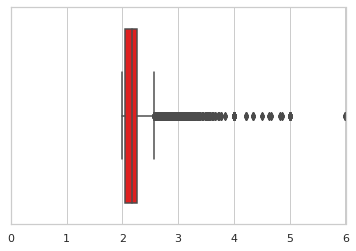

In [72]:
sns.set(style="whitegrid")
avg_count = avg_item_mb.sort_values("price").values
sns.boxplot(avg_count, color="red")
plt.xlim(0,6)

ValueError: x and y must be the same size

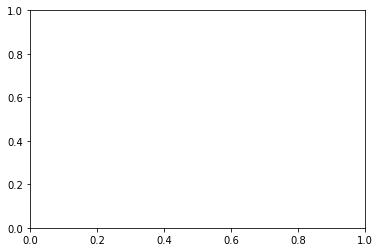

In [55]:
avg_count = avg_item_mb.sort_values("price").values
x = np.arange(len(avg_count))
plt.scatter(x, avg_count)